In [35]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd

In [2]:
def parse_ip_port(hex_ip, port):
    """Parses a hexadecimal IP and port to a human-readable string."""
    try:
        # ip = '.'.join(str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2))
        # return f"{ip}:{port}"
        # return f"{ip}"
        
        ip_list=[str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2)]
        return f"Host-{ip_list[2]}"
        
    except ValueError as e:
        print(f"Error parsing IP:Port - {hex_ip}:{port}")
        return "0.0.0.0:0"

Start time: 1000001838, End time: 1001674392


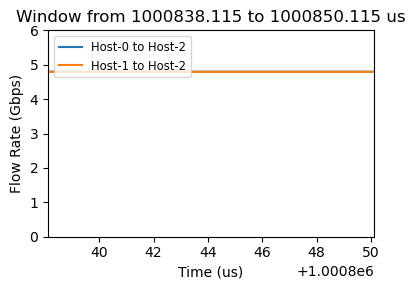

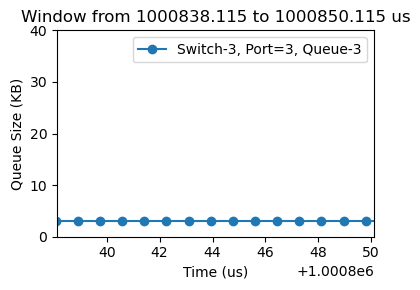

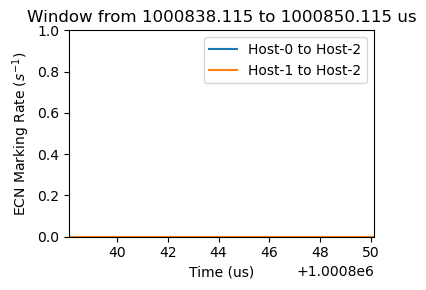

No drop events found in the log file. Stopping execution.


In [34]:
data_dir=f"/data2/lichenni/path_cc20_test/shard0_nflows1_nhosts3"
shard_seed=0
bw_bottleneck=10
pd_bottleneck=1000
topo_type=f"topo-pl-3-{bw_bottleneck}-{pd_bottleneck}"
# Calculate stats using a 1ms window
# Read and parse the log file
log_file_path = f'{data_dir}/mix_{topo_type}_s{shard_seed}.log'  # Replace with your actual log file path
flow_rate_bottom=0
flow_rate_top=6

queue_size_top=40
queue_size_bottom=0
ecn_mark_top = 1.0  # Maximum value for the y-axis
ecn_mark_bottom = 0.0  # Minimum value for the y-axis
pfc_top = 0.2  # Maximum value for the y-axis
pfc_bottom = 0.0  # Minimum value for the y-axis
drop_top = 1000  # Maximum value for the y-axis
drop_bottom = 0.0  # Minimum value for the y-axis

xlim_range=4000*3
xtick_unit=1000
xtick_unit_str='us'

# Initialize data structures
flow_packets =  defaultdict(list)
 # Key: (src, dst), Value: list of timestamps (ns)
ecn_marks = defaultdict(list)  # Timestamps of ECN-marked packets
queue_sizes = defaultdict(list)  # Key: (node, port, queue), Value: list of (timestamp, queue size) tuples

start_time=None
end_time=None
with open(log_file_path, 'r') as file:
    for line in file:
        parts = line.split()
        
        event_type = parts[4]  # Assuming the event type is at this position
        pkt_type = parts[10]  # Assuming the packet type is at this position
        node = parts[1].split(':')[1]
        port, queue = map(int, parts[2].split(':'))
        
        timestamp_ns = int(parts[0])
        
        src = parse_ip_port(parts[6], parts[8])
        dst = parse_ip_port(parts[7], parts[9])
            
        if node=='3' and (event_type == "Enqu" and pkt_type=='U'):
            queue_size = float(parts[3])
            # Store queue size by node, port, and queue
            # queue_sizes[(node, port, queue)].append((timestamp_ns, queue_size))
            queue_sizes[(node, port, queue)].append((timestamp_ns, queue_size))
            if start_time is None:
                start_time=timestamp_ns
            end_time=timestamp_ns
        if node=='3' and (event_type == "Dequ" and pkt_type=='U'):  # Change "recv" to the actual keyword for receive events
            ecn_marked = 1 if parts[5].split(':')[1]!='0' else 0
            ecn_marks[(src, dst)].append([timestamp_ns,ecn_marked])
            
        if node=='3' and (event_type == "Recv" and pkt_type=='U'):  # Change "recv" to the actual keyword for receive events
            
            packet_size = int(parts[-1].split('(')[-1][:-1])
            # Store packet timestamp by flow
            flow_packets[(src, dst)].append((timestamp_ns,packet_size))

print(f"Start time: {start_time}, End time: {end_time}")
x_left=(start_time+end_time)//2/xtick_unit
x_right=x_left+xlim_range/xtick_unit
    
flow_rates = defaultdict(list) 
for (src, dst), data in flow_packets.items():
    start_time = data[0][0]
    data=np.array(data)
    for i in range(1,len(data)):
        window_bytes = np.sum(data[:i+1,1])
        window_size_ns=data[i][0]-start_time
        window_rate_gbps = (window_bytes * 8) / (window_size_ns / 1e9) / 1e9  # Convert to Mbps
        flow_rates[(src, dst)].append((data[i][0], window_rate_gbps))

# Plot flow rates over time for a selected flow (for simplicity, plot the first flow)
plt.figure(figsize=(4, 3))
# Iterate over each flow and plot its flow rate over time
for flow_id, rates in flow_rates.items():
    times, rates = zip(*rates)
    plt.plot(np.array(times)/xtick_unit, rates, label=f"{flow_id[0]} to {flow_id[1]}")

plt.xlabel(f'Time ({xtick_unit_str})')
plt.ylabel('Flow Rate (Gbps)')
plt.xlim(left=x_left,right=x_right)
plt.ylim(top=flow_rate_top,bottom=flow_rate_bottom)
plt.title(f'Window from {x_left} to {x_right} {xtick_unit_str}')
plt.legend(loc='upper left', fontsize='small')  # Adjust legend placement
plt.tight_layout()  # Adjust layout to make room for the legend

plt.show()

plt.figure(figsize=(4, 3))
# Plot queue size over time for a specific queue (for simplicity, plot the first queue)
for selected_queue in queue_sizes.keys():
    timestamps, mean_sizes = zip(*queue_sizes[selected_queue])
    
    # plt.plot(np.array(timestamps) / 1e9, np.array(mean_sizes) / 1024, '-o', label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
    plt.plot(np.array(timestamps)/xtick_unit, np.array(mean_sizes) / 1024, '-o', label=f"Switch-{selected_queue[0]}, Port={selected_queue[1]}, Queue-{selected_queue[2]}")
plt.xlabel(f'Time ({xtick_unit_str})')
plt.ylabel('Queue Size (KB)')
plt.xlim(left=x_left,right=x_right)
plt.ylim(top=queue_size_top,bottom=queue_size_bottom)
plt.title(f'Window from {x_left} to {x_right} {xtick_unit_str}')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate ECN marking rate
ecn_mark_rates = defaultdict(list)
for (src, dst), data in ecn_marks.items():
    start_time = data[0][0]
    data=np.array(data)
    for i in range(1,len(data)):
        ecn_mark_freq = np.sum(data[:i+1,1])
        ecn_size_ns=data[i][0]-start_time
        ecn_rate_gbps =ecn_mark_freq / (ecn_size_ns / 1e9)  # Convert to Mbps 
        ecn_mark_rates[(src, dst)].append((data[i][0], ecn_rate_gbps))
        
# Plot ECN marking rate over time for a selected flow
plt.figure(figsize=(4, 3))
for flow_id, rates in ecn_mark_rates.items():
    times, rates = zip(*rates)
    plt.plot(np.array(times)/xtick_unit, rates, label=f"{flow_id[0]} to {flow_id[1]}")
# plt.plot(np.array(times) / 1e9, rates, '-o', label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
plt.xlabel(f'Time ({xtick_unit_str})')
plt.ylabel('ECN Marking Rate ($s^{-1}$)')
plt.xlim(left=x_left,right=x_right)
plt.ylim(top=ecn_mark_top, bottom=ecn_mark_bottom)
plt.title(f'Window from {x_left} to {x_right} {xtick_unit_str}')
plt.legend()
plt.tight_layout()
plt.show()

# Read the log file and extract drop events with node, port, and queue information
log_file_path = f'{data_dir}/pdrop_{topo_type}_s{shard_seed}.txt'
drop_events = []
with open(log_file_path, 'r') as file:
    for line in file:
        if 'Drop: queue' in line:
            parts = line.split()
            timestamp = int(parts[0])
            node_id = int(parts[1])
            port_queue_part = parts[3].split(':')[1]  # Extract "queue:1,3" part
            port = int(port_queue_part.split(',')[0])
            queue = int(port_queue_part.split(',')[1])
            drop_events.append((timestamp, node_id, port, queue))

# Check if the drop_events list is empty
# Check if the drop_events list is empty
if not drop_events:
    print("No drop events found in the log file. Stopping execution.")
else:
    # Dictionary to store drop frequency for each (node, port, queue) combination
    drop_frequency = defaultdict(list)

    # Iterate over drop events and calculate drop frequency for each time window and combination
    for timestamp, node_id, port, queue in drop_events:
        key = (node_id, port,queue)
        drop_frequency[key].append((timestamp,1))

    drop_freq_rates = defaultdict(list)
    for (node_id, port,queue), data in drop_frequency.items():
        start_time = data[0][0]
        data=np.array(data)
        for i in range(1,len(data)):
            drop_freq = np.sum(data[:i+1,1])
            drop_ns=data[i][0]-start_time
            drop_rate_gbps =drop_freq / (drop_ns / 1e9)  # Convert to Mbps 
            drop_freq_rates[(node_id, port,queue)].append((data[i][0], drop_rate_gbps))
        
    # Plot drop frequency over time for each unique (node, port, queue) combination
    plt.figure(figsize=(4, 3))
    # for (node_id, port, queue), time_buckets in drop_frequency.items():
    for selected_queue in drop_freq_rates.keys():
        timestamps, mean_sizes = zip(*drop_freq_rates[selected_queue])
        plt.figure(figsize=(4, 3))
        # plt.plot(np.array(timestamps) / 1e9, np.array(mean_sizes) / 1024, '-o', label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
        plt.plot(np.array(timestamps)/xtick_unit, np.array(mean_sizes), '-o', label=f"Switch-{selected_queue[0]}, Port={selected_queue[1]}, Queue-{selected_queue[2]}")

    plt.xlabel('Time (seconds)')
    plt.ylabel('Drop Frequency ($s^{-1}$)')
    plt.title(f'Packet Drop Frequency from {x_left} to {x_right} {xtick_unit_str}')
    plt.yscale('log')
    plt.ylim(top=drop_top, bottom=drop_bottom)
    plt.legend()
    plt.tight_layout()
    plt.show()

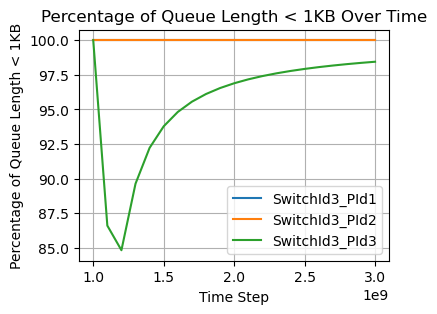

In [40]:
# Function to parse the log data
def parse_log(log_file):
    data = {"Time Step": [], "Queue ID": [], "Queue Lengths": []}
    with open(log_file, "r") as f:
        for line in f:
            if line.startswith("time:"):
                time_step = int(line.split(":")[1])
            else:
                parts = line.split()
                switch_id = int(parts[0])
                device_id = int(parts[1])
                queue_lengths = list(map(int, parts[2:]))
                data["Time Step"].append(time_step)
                data["Queue ID"].append(f"SwitchId{switch_id}_PId{device_id}")
                data["Queue Lengths"].append(queue_lengths)
    return pd.DataFrame(data)

# Function to calculate percentage of queue length < 1KB
def calculate_percentage(df):
    df["Percentage < 1KB"] = df["Queue Lengths"].apply(lambda x: sum(x[:1]) / sum(x) * 100)
    return df

# Function to plot the percentage over time for each node
def plot_percentage(df):
    plt.figure(figsize=(4, 3))
    for node_id in df["Queue ID"].unique():
        node_data = df[df["Queue ID"] == node_id]
        plt.plot(node_data["Time Step"], node_data["Percentage < 1KB"], label=f"{node_id}")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage of Queue Length < 1KB")
    plt.title("Percentage of Queue Length < 1KB Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
log_file = f"{data_dir}/qlen_topo-pl-3_s{shard_seed}.txt"
log_data = parse_log(log_file)
log_data_with_percentage = calculate_percentage(log_data)
plot_percentage(log_data_with_percentage)
